In [65]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from skimage.color import rgb2lab, lab2rgb
from skimage.io import imread, imshow

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [5]:
BATCH_SIZE = 1
IMAGE_SIZE = (256, 256)

In [6]:
train_dir = './datasets/train'
train_dataset = image_dataset_from_directory(train_dir, label_mode=None, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE)

validation_dir = './datasets/validation'
validation_dataset = image_dataset_from_directory(validation_dir, label_mode=None, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE)

test_dir = './datasets/test'
test_dataset = image_dataset_from_directory(test_dir, label_mode=None, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE)

Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.


(1, 256, 256, 3)


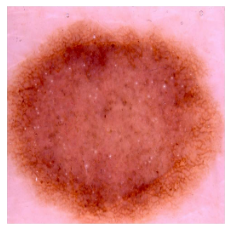

In [7]:
for images in train_dataset.take(1):
    print(images.shape)
    plt.imshow(images[0].numpy().astype("uint8"))
    plt.axis("off")

In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [118]:
def preprocess_images_batch(image_batch):
    image_batch_lab = np.zeros_like(image_batch)
    for i in range(image_batch.shape[0]):
        image_batch_lab[i] = rgb2lab(image_batch[i] / 256)
    return image_batch_lab[:, :, :, 0:1], image_batch_lab[:, :, :, 1:3]

In [30]:
# model = OurModels.OurModel(bla=bla, ...)

-14.050018 57.074356


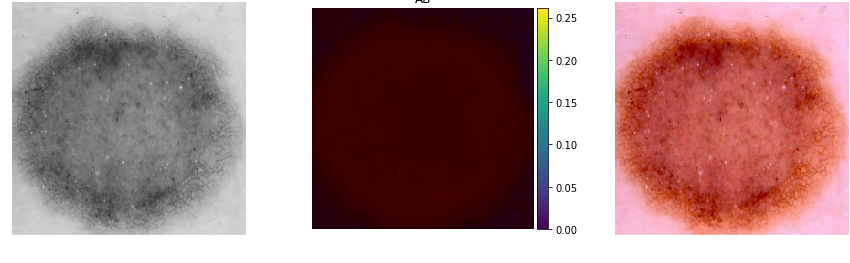

In [119]:
# test if preprocess is fine
for image_batch in train_dataset.take(1):
    l, ab = preprocess_images_batch(image_batch)
    print(np.amin(ab), np.amax(ab))

    a = ab[0,:,:,0]
    l = l[0,:,:,0]
    b = ab[0,:,:,1]

    only_l = np.dstack((l, np.zeros(l.shape), np.zeros(l.shape)))
    ab = np.dstack((np.zeros(l.shape), a, b))  # doesn't make much sense as an image

    fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(12, 4))
    imshow(lab2rgb(only_l), ax=ax0), ax0.set_title('Only L'), ax0.axis('off')
    imshow(lab2rgb(ab), ax=ax1), ax1.set_title('AB'), ax1.axis('off'),
    imshow(lab2rgb(np.dstack((l, np.dstack((a, b))))), ax=ax2), ax2.set_title('Concatenated image'), ax2.axis('off')
    plt.show()